<a href="https://colab.research.google.com/github/Carlosrnes/deep_learning_nova/blob/main/CNN/CNN_Transfer_Learning_p1_feature_extraction_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

https://colab.research.google.com/notebooks/gpu.ipynb

In [1]:
!nvidia-smi

Sat Mar 26 20:47:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### How to Load Kaggle Datasets Directly into Google Colab?

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/ 

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download data
! kaggle datasets download -d kmader/food41

100% 5.28G/5.30G [00:25<00:00, 212MB/s]
100% 5.30G/5.30G [00:25<00:00, 222MB/s]


### Libraries

In [3]:
import os, shutil
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image

###  Get Data

In [4]:
# Get data
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("food41.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [5]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("images"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 101 directories and 0 images in 'images'.
There are 0 directories and 1000 images in 'images/greek_salad'.
There are 0 directories and 1000 images in 'images/eggs_benedict'.
There are 0 directories and 1000 images in 'images/pad_thai'.
There are 0 directories and 1000 images in 'images/huevos_rancheros'.
There are 0 directories and 1000 images in 'images/frozen_yogurt'.
There are 0 directories and 1000 images in 'images/lobster_bisque'.
There are 0 directories and 1000 images in 'images/grilled_salmon'.
There are 0 directories and 1000 images in 'images/omelette'.
There are 0 directories and 1000 images in 'images/ice_cream'.
There are 0 directories and 1000 images in 'images/breakfast_burrito'.
There are 0 directories and 1000 images in 'images/french_fries'.
There are 0 directories and 1000 images in 'images/nachos'.
There are 0 directories and 1000 images in 'images/pulled_pork_sandwich'.
There are 0 directories and 1000 images in 'images/fried_calamari'.
There are 0 direc

In [6]:
# select the directory of the images (divided by class folder) - without data augmentation
data_folder = '/content/images'

list_class = os.listdir(data_folder)
list_class.sort()


print(f'{len(list_class)} Classes of foods.')
print(list_class)

101 Classes of foods.
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese',

### Data Preprocessing

In [7]:
# Set the seed
tf.random.set_seed(42)

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# rescale the Image and split into validation set
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# train set - generation
train_generator = datagen.flow_from_directory(data_folder,
                                         target_size = IMAGE_SHAPE,
                                         batch_size = BATCH_SIZE,
                                         class_mode = 'categorical',
                                         seed=42,
                                         subset = 'training')

val_generator = datagen.flow_from_directory(data_folder,
                                      target_size = IMAGE_SHAPE,
                                      batch_size = BATCH_SIZE,
                                      class_mode = 'categorical',
                                      seed=42,
                                      subset = 'validation')


Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [8]:
# Sanity Check
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 101)


### Creating a callback

In [10]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In [11]:
import tensorflow_hub as hub
from tensorflow.keras import layers

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [12]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

### Building the network

In [14]:
# Create model
resnet_model = create_model(resnet_url, num_classes=101)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

### Training the model

In [15]:
# Fit the model
resnet_history = resnet_model.fit(train_generator,
                                  epochs=5,
                                  steps_per_epoch=len(train_generator),
                                  validation_data=val_generator,
                                  validation_steps=len(val_generator),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220326-205558
Epoch 1/5
2525/2525 [==============================] - 838s 325ms/step - loss: 2.1460 - accuracy: 0.4793 - val_loss: 1.9123 - val_accuracy: 0.5329
Epoch 2/5
2525/2525 [==============================] - 705s 279ms/step - loss: 1.5878 - accuracy: 0.5946 - val_loss: 1.9148 - val_accuracy: 0.5411
Epoch 3/5
2525/2525 [==============================] - 658s 261ms/step - loss: 1.3969 - accuracy: 0.6349 - val_loss: 1.9369 - val_accuracy: 0.5478
Epoch 4/5
2525/2525 [==============================] - 646s 256ms/step - loss: 1.2702 - accuracy: 0.6630 - val_loss: 1.9457 - val_accuracy: 0.5544
Epoch 5/5
2525/2525 [==============================] - 644s 255ms/step - loss: 1.1736 - accuracy: 0.6839 - val_loss: 2.0117 - val_accuracy: 0.5523


In [16]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

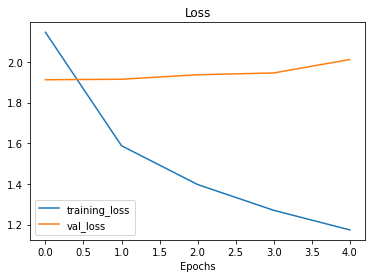

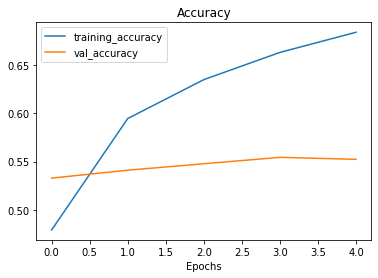

In [17]:
plot_loss_curves(resnet_history)

In [18]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 101)               206949    
                                                                 
Total params: 23,771,749
Trainable params: 206,949
Non-trainable params: 23,564,800
_________________________________________________________________


In [19]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=101)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_generator, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_generator),
                                              validation_data=val_generator,
                                              validation_steps=len(val_generator),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220326-215646
Epoch 1/5
2525/2525 [==============================] - 594s 230ms/step - loss: 1.6422 - accuracy: 0.5961 - val_loss: 1.3179 - val_accuracy: 0.6624
Epoch 2/5
2525/2525 [==============================] - 571s 226ms/step - loss: 1.1374 - accuracy: 0.7030 - val_loss: 1.2223 - val_accuracy: 0.6829
Epoch 3/5
2525/2525 [==============================] - 568s 225ms/step - loss: 0.9939 - accuracy: 0.7355 - val_loss: 1.2047 - val_accuracy: 0.6901
Epoch 4/5
2525/2525 [==============================] - 568s 225ms/step - loss: 0.9048 - accuracy: 0.7592 - val_loss: 1.1908 - val_accuracy: 0.6958
Epoch 5/5
2525/2525 [==============================] - 584s 231ms/step - loss: 0.8373 - accuracy: 0.7771 - val_loss: 1.1955 - val_accuracy: 0.6938


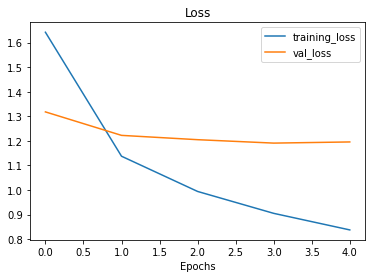

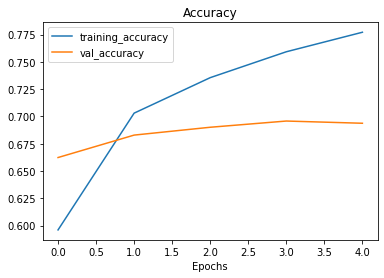

In [20]:
plot_loss_curves(efficientnet_history)

In [21]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,945
Trainable params: 129,381
Non-trainable params: 4,049,564
_________________________________________________________________


### Heatmap - class activation heatmap for an image classification model

In [22]:
# The Grad-CAM algorithm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [23]:
# function to overlap the heatmap and the real image

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

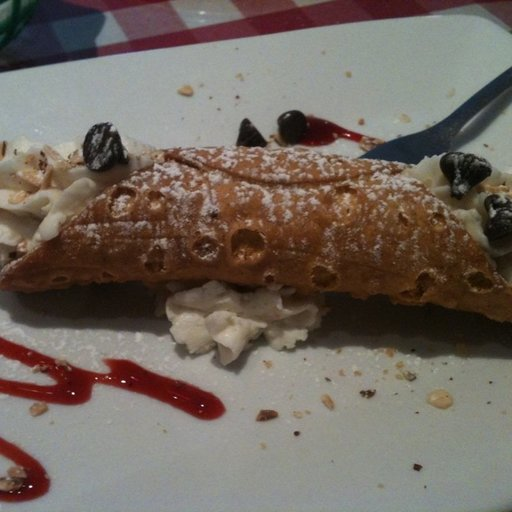

In [42]:
# Test in one image prodiction - define the parameters:

# name form model.summary() of the last CNN layer
last_conv_layer_name = 'feature_extraction_layer'

# check one image sample
# The local path to our target image
img_path = '/content/images/cannoli/1007970.jpg'

# Size of the training
display(Image(filename=img_path, width=224, height=224))

In [43]:
# Display the image

# Prepare image
img_size = (224,224)
img_array = get_img_array(img_path, size=img_size)


# Remove last layer's softmax
# model.layers[-1].activation = None

# Print what the top predicted class is
preds = efficientnet_model.predict(img_array)
print(len(preds[0]))
print("Predicted:", list_class[np.argmax(preds[0])])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, efficientnet_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)

101
Predicted: paella


InvalidArgumentError: ignored